# Statistical API - Request Examples

This notebook was created as a companion notebook to the [Statitical API webinar](https://youtu.be/4JviobxqTO8). 

## Import modules and authenticate at Sentinel Hub

In [92]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import requests
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sentinelhub import SentinelHubStatistical, DataCollection, CRS, BBox, bbox_to_dimensions, \
    Geometry, SHConfig, parse_time, parse_time_interval, SentinelHubStatisticalDownloadClient

In [95]:
# Replace the client ID and client secret below with your own
client_id = "<your_c>"
client_secret = "6RdPgeW7bOtzRb4m7Sul"

client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)

**Note: Statistical API uses your processing units. It's easy to set a long time-range and daily aggregations, so keep this in mind.**

## How does SH Statistical API calculate statistics?

In this part, we would like to demonstrate how Statistical API calculates statistics. To do so, we first calculate statistics "manually" by first requesting an image with Process API and then calculating statistics for the image using numpy. Next, we run the statistical API request and show that the results of the request are the same as the results of the manual calculation. 

### Define AOI and evalscript

Here we define AOI and evalscript which we will use in both requests; Statistical API and Process API.

In [79]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "data",
        bands: 1,
        sampleType: "FLOAT32"  //FLOAT32 is used in process API to get floating NDVI values for statistics
      },
      {
        id: "dataMask",
        bands: 1
      }]
  }
}

function evaluatePixel(samples) {
    return {
        data: [index(samples.B08, samples.B04)],
        dataMask: [samples.dataMask]
        };
}
"""

bounds = {"geometry":{
  "type": "Polygon",
  "coordinates": [
    [
      [
        14.311462,
        45.79756
      ],
      [
        14.31188,
        45.797111
      ],
      [
        14.311977,
        45.79658
      ],
      [
        14.312653,
        45.795839
      ],
      [
        14.313372,
        45.795443
      ],
      [
        14.314305,
        45.795346
      ],
      [
        14.31496,
        45.795091
      ],
      [
        14.31525,
        45.795278
      ],
      [
        14.31585,
        45.795368
      ],
      [
        14.315818,
        45.795593
      ],
      [
        14.315335,
        45.795967
      ],
      [
        14.314895,
        45.796453
      ],
      [
        14.31393,
        45.796939
      ],
      [
        14.312492,
        45.797425
      ],
      [
        14.311462,
        45.79756
      ]
    ]
  ]
}}

### Process API + statistics on image with numpy

In [80]:
# Request an image
process_request = {
  "input": {
    "bounds": bounds,
    "data": [
      {
        "type": "S2L2A",
        "dataFilter": {
            "timeRange": {
                "from": "2021-10-02T00:00:00Z",
                "to": "2021-10-03T00:00:00Z"
              },
            "mosaickingOrder": "leastRecent"
        },
        "processing": {
            "upsampling": "BICUBIC"
        }
      }
    ]
  },
  "evalscript": evalscript,
  "output":{
    "resx": 0.00010,
    "resy": 0.00010,
    "responses": [
         {
            "identifier": "data",
            "format": {
                "type": "image/tiff"
            }
        },
        {
            "identifier": "dataMask",
            "format": {
                "type": "image/tiff"
            }
        }
    ]
  }
}

headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/x-tar'
}

response = oauth.request("POST", url="https://services.sentinel-hub.com/api/v1/process", headers=headers, json=process_request)
tar = tarfile.open(fileobj=io.BytesIO(response.content))

Let's display the requested image. It will show NDVI values in the requested polygon.

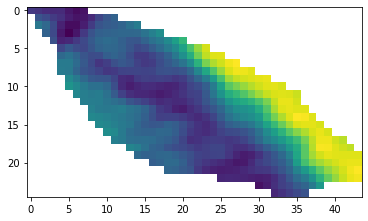

In [81]:
# Extract our data.tif output form the tar file and save it as numpy array
im_array = imread(BytesIO(tar.extractfile(tar.getmember("data.tif")).read(-1)))
im_array = im_array.astype('float')
# Treat value 0 as nans
im_array[im_array == 0] = np.nan
plt.imshow(im_array, interpolation='nearest')
plt.show()

Let's check the size of the image:

In [82]:
shape = im_array.shape
shape[0] * shape [1]

1100

The image consist of 1100 pixels. 

Now we will manually calculate the same statistics that we requested with Statistical API above, i.e.:  
- minimum value 
- maximum value
- mean value
- standard deviation
- histogram with 5 bins
- 10th, 30th, 40th, 50th, and 90th percentils

In [83]:
manual_stattics = {
    "min": np.nanmin(im_array),
    "max": np.nanmax(im_array),
    "mean": np.nanmean(im_array),
    "stDev": np.nanstd(im_array),
    "hist": np.histogram(im_array[~np.isnan(im_array)], bins=5),
    "percentiles": np.percentile(im_array[~np.isnan(im_array)], [10, 30, 40, 50, 90])
}
manual_stattics

{'min': 0.12717677652835846,
 'max': 0.5160512328147888,
 'mean': 0.28425120391382225,
 'stDev': 0.10754383799787968,
 'hist': (array([150, 211,  83,  37,  90]),
  array([0.12717678, 0.20495167, 0.28272656, 0.36050145, 0.43827634,
         0.51605123])),
 'percentiles': array([0.17404507, 0.21141253, 0.23049518, 0.2516419 , 0.48868692])}

### Statistics with Statistical API

In [84]:
statistical_request = {
  "input": {
    "bounds": bounds,
    "data": [
      {
        "type": "S2L2A",
        "dataFilter": {
            "mosaickingOrder": "leastRecent"
        },
        "processing": {
            "upsampling": "BICUBIC"
        }
      }
    ]
  },
  "aggregation": {
    "timeRange": {
            "from": "2021-10-02T00:00:00Z",
            "to": "2021-10-03T00:00:00Z"
      },
      "aggregationInterval": {
          "of": "P1D"
      },
    "evalscript": evalscript,
    "resx": 0.00010,
    "resy": 0.00010,
  },
  "calculations": {
      "default": {
         "statistics": {
              "default": {
                  "percentiles": {
                      "k": [10, 30, 40, 50, 90],
                      "interpolation": "higher"
                  }
              }
          },
          "histograms": {
              "default": {
                  "nBins": 5
              }
          }
      }
  }
}

headers = {
  'Content-Type': 'application/json',
   'Accept': 'application/json'
}

response = oauth.request("POST", url="https://services.sentinel-hub.com/api/v1/statistics" , headers=headers, json=statistical_request)
sh_statistics = response.json()
sh_statistics

{'data': [{'interval': {'from': '2021-10-02T00:00:00Z',
    'to': '2021-10-03T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 0.12717677652835846,
        'max': 0.5160512328147888,
        'mean': 0.2842512039138222,
        'stDev': 0.10754383799787971,
        'sampleCount': 1100,
        'noDataCount': 529,
        'percentiles': {'50.0': 0.2516418993473053,
         '10.0': 0.17404507100582123,
         '40.0': 0.23049518465995789,
         '90.0': 0.4886869192123413,
         '30.0': 0.21141253411769867}},
       'histogram': {'bins': [{'lowEdge': 0.12717677652835846,
          'highEdge': 0.20495166778564453,
          'count': 150},
         {'lowEdge': 0.20495166778564453,
          'highEdge': 0.2827265590429306,
          'count': 211},
         {'lowEdge': 0.2827265590429306,
          'highEdge': 0.36050145030021663,
          'count': 83},
         {'lowEdge': 0.36050145030021663,
          'highEdge': 0.4382763415575027,
          'count': 37},
   

### Compare the results

In [85]:
# Statistical api
sh_statistics

{'data': [{'interval': {'from': '2021-10-02T00:00:00Z',
    'to': '2021-10-03T00:00:00Z'},
   'outputs': {'data': {'bands': {'B0': {'stats': {'min': 0.12717677652835846,
        'max': 0.5160512328147888,
        'mean': 0.2842512039138222,
        'stDev': 0.10754383799787971,
        'sampleCount': 1100,
        'noDataCount': 529,
        'percentiles': {'50.0': 0.2516418993473053,
         '10.0': 0.17404507100582123,
         '40.0': 0.23049518465995789,
         '90.0': 0.4886869192123413,
         '30.0': 0.21141253411769867}},
       'histogram': {'bins': [{'lowEdge': 0.12717677652835846,
          'highEdge': 0.20495166778564453,
          'count': 150},
         {'lowEdge': 0.20495166778564453,
          'highEdge': 0.2827265590429306,
          'count': 211},
         {'lowEdge': 0.2827265590429306,
          'highEdge': 0.36050145030021663,
          'count': 83},
         {'lowEdge': 0.36050145030021663,
          'highEdge': 0.4382763415575027,
          'count': 37},
   

In [86]:
# Process API + numpay
manual_stattics

{'min': 0.12717677652835846,
 'max': 0.5160512328147888,
 'mean': 0.28425120391382225,
 'stDev': 0.10754383799787968,
 'hist': (array([150, 211,  83,  37,  90]),
  array([0.12717678, 0.20495167, 0.28272656, 0.36050145, 0.43827634,
         0.51605123])),
 'percentiles': array([0.17404507, 0.21141253, 0.23049518, 0.2516419 , 0.48868692])}

We see that we get the same values in both cases, which is exactly what we wanted to show. 
Note that sampleCount is 1100, which corresponds to the number of all pixels in the image. However, only pixels within the polygon were used for calcualting the statistics, because we excluded pixels outside of the polygon in our evalscript with this line `dataMask: [samples.dataMask]`. 529 pixels were excluded, which is reported as `noDataCount` by the Statistical API.  

To conclude, Statistical API generates the image based on requested parameters and evalscript (in the same ways as Process API) and then calculates the statistics based on this image.

## Run any statistical API request from Requests Builder

It's easiest to construct API requests using [Requests Builder's](https://apps.sentinel-hub.com/requests-builder/) interface.

To run the request from [Requests Builder](https://apps.sentinel-hub.com/requests-builder/), do the following: 
1. navigate to Requests Builder, log in and toggle on the _Statistical_ API option.
2. use the user interface to build your request
3. copy the request in the sh-py format from the _Request Preview_ window
4. replace the client ID and client Secret at the top with either your client ID and client secret, or, in this notebook, just with client_id and cliend_secret variables, as we have them defined above. 
5. add `response` at the bottom to run the request

![SNOWFALL](request_preview.png)

The requests below have been copied from the Requests Builder Preview Window.

### NDVI statistics for a single day - Sentinel-2 L2A

Time interval for this request was set from 2022-01-25 to 2022-01-26. 
Aggregations are set to P1D. 

Note that in case there's no data available in the specific time frame, the request will return an error.


In [87]:
from sentinelhub import SHConfig, SentinelHubStatistical, BBox, Geometry, DataCollection, CRS

# Credentials
config = SHConfig()
config.sh_client_id = client_id
config.sh_client_secret = client_secret

evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "NDVI",
        bands: ["NDVI"]
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    let ndvi = (samples.B08 - samples.B04) / (samples.B08+samples.B04);
    return {
        NDVI: [ndvi],
        dataMask: [samples.dataMask]
    };
}

"""

bbox = BBox(bbox=[14.43807, 45.978388, 14.449997, 45.986768], crs=CRS.WGS84)
geometry = Geometry(geometry={"type":"Polygon","coordinates":[[[14.43807,45.985337],[14.442789,45.978716],[14.444548,45.979045],[14.445106,45.978388],[14.449997,45.980118],[14.445707,45.983846],[14.443089,45.98322],[14.44236,45.984204],[14.444591,45.984621],[14.442789,45.986768],[14.43807,45.985337]]]}, crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2022-01-25T00:00:00Z', '2022-01-26T00:00:00Z'),
        aggregation_interval='P1D',
        size=[512, 517.657],        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L2A,                        
      ),
    ],
    bbox=bbox,
    geometry=geometry,
    config=config
)

response = request.get_data()
response

[{'data': [{'interval': {'from': '2022-01-25T00:00:00Z',
     'to': '2022-01-26T00:00:00Z'},
    'outputs': {'NDVI': {'bands': {'NDVI': {'stats': {'min': 0.11903064697980881,
         'max': 0.5644171833992004,
         'mean': 0.19506650719444532,
         'stDev': 0.06335584426277424,
         'sampleCount': 264704,
         'noDataCount': 141236}}}}}}],
  'status': 'OK'}]

### NDVI statistics for 6 months, monthly aggregations - Sentinel-2 L2A

Time interval for this request was set from 2021-01-01 to 2021-07-30. 
Aggregations are set to P1M, returning 6 intervals, each covering one month. 

In [88]:
from sentinelhub import SHConfig, SentinelHubStatistical, BBox, Geometry, DataCollection, CRS

# Credentials
config = SHConfig()
config.sh_client_id = client_id
config.sh_client_secret = client_secret

evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "NDVI",
        bands: ["NDVI"]
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    let ndvi = (samples.B08 - samples.B04) / (samples.B08+samples.B04);
    return {
        NDVI: [ndvi],
        dataMask: [samples.dataMask]
    };
}

"""

bbox = BBox(bbox=[14.43807, 45.978388, 14.449997, 45.986768], crs=CRS.WGS84)
geometry = Geometry(geometry={"type":"Polygon","coordinates":[[[14.43807,45.985337],[14.442789,45.978716],[14.444548,45.979045],[14.445106,45.978388],[14.449997,45.980118],[14.445707,45.983846],[14.443089,45.98322],[14.44236,45.984204],[14.444591,45.984621],[14.442789,45.986768],[14.43807,45.985337]]]}, crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2021-01-01T00:00:00Z', '2021-07-30T23:59:59Z'),
        aggregation_interval='P1M',
        size=[512, 517.657],        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L2A,                        
      ),
    ],
    bbox=bbox,
    geometry=geometry,
    config=config
)

response = request.get_data()
response

[{'data': [{'interval': {'from': '2021-01-01T00:00:00Z',
     'to': '2021-02-01T00:00:00Z'},
    'outputs': {'NDVI': {'bands': {'NDVI': {'stats': {'min': -0.009306260384619236,
         'max': 0.05112960934638977,
         'mean': 0.019889125026077203,
         'stDev': 0.007759267052060924,
         'sampleCount': 264704,
         'noDataCount': 141236}}}}}},
   {'interval': {'from': '2021-02-01T00:00:00Z', 'to': '2021-03-01T00:00:00Z'},
    'outputs': {'NDVI': {'bands': {'NDVI': {'stats': {'min': 0.16998468339443207,
         'max': 0.46969306468963623,
         'mean': 0.26567304173508294,
         'stDev': 0.042864532271783634,
         'sampleCount': 264704,
         'noDataCount': 141236}}}}}},
   {'interval': {'from': '2021-03-01T00:00:00Z', 'to': '2021-04-01T00:00:00Z'},
    'outputs': {'NDVI': {'bands': {'NDVI': {'stats': {'min': 0.12366737425327301,
         'max': 0.6077755689620972,
         'mean': 0.24903059921593887,
         'stDev': 0.06863118938717337,
         'sampl

### NDVI statistics for 6 months, monthly aggregations - Landsat 8

This request is the same as above, but the collection is changed to Landsat 8. To change the collection, one only has to:
- replace the collection in Requests Builder or directly in the request
- replace the NDVI bands to match Landsat 8. 

In [89]:
from sentinelhub import SHConfig, SentinelHubStatistical, BBox, Geometry, DataCollection, CRS

# Credentials
config = SHConfig()
config.sh_client_id = client_id
config.sh_client_secret = client_secret

evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B05",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "NDVI",
        bands: ["NDVI"]
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    let ndvi = (samples.B05 - samples.B04) / (samples.B05+samples.B04);
    return {
        NDVI: [ndvi],
        dataMask: [samples.dataMask]
    };
}

"""

bbox = BBox(bbox=[14.43807, 45.978388, 14.449997, 45.986768], crs=CRS.WGS84)
geometry = Geometry(geometry={"type":"Polygon","coordinates":[[[14.43807,45.985337],[14.442789,45.978716],[14.444548,45.979045],[14.445106,45.978388],[14.449997,45.980118],[14.445707,45.983846],[14.443089,45.98322],[14.44236,45.984204],[14.444591,45.984621],[14.442789,45.986768],[14.43807,45.985337]]]}, crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2021-01-01T00:00:00Z', '2021-07-30T23:59:59Z'),
        aggregation_interval='P30D',
        size=[512, 517.657],        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.LANDSAT_OT_L2,                        
      ),
    ],
    bbox=bbox,
    geometry=geometry,
    config=config
)

response = request.get_data()
response

[{'data': [{'interval': {'from': '2021-01-01T00:00:00Z',
     'to': '2021-01-31T00:00:00Z'},
    'outputs': {'NDVI': {'bands': {'NDVI': {'stats': {'min': 0.2804112136363983,
         'max': 0.600660502910614,
         'mean': 0.4074056929175689,
         'stDev': 0.05899712086356643,
         'sampleCount': 264704,
         'noDataCount': 141236}}}}}},
   {'interval': {'from': '2021-01-31T00:00:00Z', 'to': '2021-03-02T00:00:00Z'},
    'outputs': {'NDVI': {'bands': {'NDVI': {'stats': {'min': 0.21140876412391663,
         'max': 0.44373634457588196,
         'mean': 0.29828984253068563,
         'stDev': 0.04167081259233397,
         'sampleCount': 264704,
         'noDataCount': 141236}}}}}},
   {'interval': {'from': '2021-03-02T00:00:00Z', 'to': '2021-04-01T00:00:00Z'},
    'outputs': {'NDVI': {'bands': {'NDVI': {'stats': {'min': -0.03023025020956993,
         'max': -0.009512590244412422,
         'mean': -0.019385796673209298,
         'stDev': 0.004005856347569613,
         'sampleC

### Run a multi-band statistical request

This request shows how you can manipulate your outputs and their names. The request has 2 general outputs, called `NDVIbands` and `NDMIbands`, each returning 2 bands and the index itself. Outputs and bands are named in the `function setup()`, then called and returned in the `function evaluatePixel(samples)`. Inspect the results to see how naming your bands changes the resulting JSON. 

In [68]:
from sentinelhub import SHConfig, SentinelHubStatistical, BBox, Geometry, DataCollection, CRS

# Credentials
config = SHConfig()
config.sh_client_id = client_id
config.sh_client_secret = client_secret

evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B03",
        "B04",
        "B08",
        "B11",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "NDVIbands",
        bands: ["B04", "B08", "NDVI"]
      },
      {
        id: "NDMIbands",
        bands: ["B03","B11","NDMI"]
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    let ndvi = (samples.B08 - samples.B04) / (samples.B08+samples.B04);
    let ndmi = (samples.B03 - samples.B11) / (samples.B03+samples.B11);
    return {
        NDVIbands: [samples.B04, samples.B08, ndvi],
        NDMIbands: [samples.B03, samples.B11, ndmi],
        dataMask: [samples.dataMask]
    };
}

"""

bbox = BBox(bbox=[14.43807, 45.978388, 14.449997, 45.986768], crs=CRS.WGS84)
geometry = Geometry(geometry={"type":"Polygon","coordinates":[[[14.43807,45.985337],[14.442789,45.978716],[14.444548,45.979045],[14.445106,45.978388],[14.449997,45.980118],[14.445707,45.983846],[14.443089,45.98322],[14.44236,45.984204],[14.444591,45.984621],[14.442789,45.986768],[14.43807,45.985337]]]}, crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2021-02-01T00:00:00Z', '2021-03-30T23:59:59Z'),
        aggregation_interval='P1M',
        size=[512, 517.657],        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L2A,                        
      ),
    ],
    bbox=bbox,
    geometry=geometry,
    config=config
)

response = request.get_data()
response

[{'data': [{'interval': {'from': '2021-02-01T00:00:00Z',
     'to': '2021-03-01T00:00:00Z'},
    'outputs': {'NDMIbands': {'bands': {'B03': {'stats': {'min': 0.053199999034404755,
         'max': 0.13420000672340393,
         'mean': 0.09822341737125981,
         'stDev': 0.013013923400378708,
         'sampleCount': 264704,
         'noDataCount': 141236}},
       'B11': {'stats': {'min': 0.17630000412464142,
         'max': 0.34630000591278076,
         'mean': 0.2774841450814966,
         'stDev': 0.04031132063588604,
         'sampleCount': 264704,
         'noDataCount': 141236}},
       'NDMI': {'stats': {'min': -0.6306146383285522,
         'max': -0.27061426639556885,
         'mean': -0.47529485860199644,
         'stDev': 0.038161040750366824,
         'sampleCount': 264704,
         'noDataCount': 141236}}}},
     'NDVIbands': {'bands': {'B04': {'stats': {'min': 0.06469999998807907,
         'max': 0.16439999639987946,
         'mean': 0.11773806747663258,
         'stDev': 

## Run a request from documentation

With our authentication above, we can simply paste in any example request from documentation and run it. Example requests from documentation are in CURL format. 
Find documentation examples [here](https://docs.sentinel-hub.com/api/latest/api/statistical/examples/).

This request names the output `output_B04` in `function setup()` and returns a single band B04 as its band in `function evaluatePixel()`. 
Time-range is set to one day 2020-07-04/2020-07-05, and aggregation is set to P1D. 

In [69]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "output_B04",
        bands: 1,
        sampleType: "FLOAT32"
      },
      {
        id: "dataMask",
        bands: 1
      }]
  }
}
function evaluatePixel(samples) {
    return {
        output_B04: [samples.B04],
        dataMask: [samples.dataMask]
        }
}
"""

stats_request = {
  "input": {
    "bounds": {
      "bbox": [414315, 4958219, 414859, 4958819],
    "properties": {
        "crs": "http://www.opengis.net/def/crs/EPSG/0/32633"
        }
    },
    "data": [
      {
        "type": "sentinel-2-l2a",
        "dataFilter": {
            "mosaickingOrder": "leastRecent"
        },
      }
    ]
  },
  "aggregation": {
    "timeRange": {
            "from": "2020-07-04T00:00:00Z",
            "to": "2020-07-05T00:00:00Z"
      },
    "aggregationInterval": {
        "of": "P1D"
    },
    "evalscript": evalscript,
    "resx": 10,
    "resy": 10
  }
}

headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json'
}

url = "https://services.sentinel-hub.com/api/v1/statistics"
response = oauth.request("POST", url=url , headers=headers, json=stats_request)
sh_statistics = response.json()
sh_statistics

{'data': [{'interval': {'from': '2020-07-04T00:00:00Z',
    'to': '2020-07-05T00:00:00Z'},
   'outputs': {'output_B04': {'bands': {'B0': {'stats': {'min': 0.07970000058412552,
        'max': 0.30959999561309814,
        'mean': 0.11471141986778864,
        'stDev': 0.034298170449733226,
        'sampleCount': 3240,
        'noDataCount': 0}}}}}}],
 'status': 'OK'}

## Exluding pixels - NDVI statistics with invalid, no-data and water pixels excluded

The following request uses dataMask output to exclude specific pixels. If dataMask = 0, the pixel is considered to have no-data, and if it's 1, the pixel is considered to have data. Pixels that are considered to not have data are excluded from the calculation. 

The user can add additional pixels to the dataMask output to also exclude water pixels, invalid pixels, etc. 

- no-data pixels are excluded by simply outputting dataMask, which is mandatory
- water pixels are excluded by creating a variable, checking if SCL band == 6 and assigning 0 to the variable
- invalid pixels are excluded by creating a variable, checking if all the bands = 0, then assigning 0 to the variable

Finally, all three are multiplied in the dataMask output. If any of the three = 0, the result will be 0 and the pixel is excluded from the calculation. 

In [91]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "SCL",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "ndvi",
        bands: ["NDVI"]
      },
      {
        id: "dataMask",
        bands: 1
      }]
  }
}

function evaluatePixel(samples) {
    let ndvi = (samples.B08 - samples.B04)/(samples.B08 + samples.B04)
    
    var validNDVIMask = 1
    if (samples.B04 + samples.B08 == 0 ){ //check if all the bands are 0
        validNDVIMask = 0
    }
    
    var noWaterMask = 1
    if (samples.SCL == 6 ){ //check if pixels are classified as water using SCL band
        noWaterMask = 0
    }

    return {
        ndvi: [ndvi],
        dataMask: [samples.dataMask * validNDVIMask * noWaterMask]  //if even one of the three exclusion criteria is 0, the pixel will be excluded
    }
}
"""


stats_request = {
  "input": {
   "bounds": {
      "geometry": {
          "type": "Polygon",
          "coordinates": [
            [
               [
        14.43807,
        45.985337
      ],
      [
        14.442789,
        45.978716
      ],
      [
        14.444548,
        45.979045
      ],
      [
        14.445106,
        45.978388
      ],
      [
        14.449997,
        45.980118
      ],
      [
        14.445707,
        45.983846
      ],
      [
        14.443089,
        45.98322
      ],
      [
        14.44236,
        45.984204
      ],
      [
        14.444591,
        45.984621
      ],
      [
        14.442789,
        45.986768
      ],
      [
        14.43807,
        45.985337
      ]
            ]
          ]
        },
    "properties": {
        "crs": "http://www.opengis.net/def/crs/EPSG/0/32633"
        }
    },
    "data": [
      {
        "type": "sentinel-2-l2a",
        "dataFilter": {
            "mosaickingOrder": "leastCC"
        }
      }
    ]
  },
  "aggregation": {
    "timeRange": {
        "from": "2020-01-01T00:00:00Z",
        "to": "2020-12-31T00:00:00Z"
      },
    "aggregationInterval": {
        "of": "P30D"
    },
    "evalscript": evalscript,
    "resx": 10,
    "resy": 10
  }
}

headers = {
  'Content-Type': 'application/json',
  'Accept': 'application/json'
}

url = "https://services.sentinel-hub.com/api/v1/statistics"

response = oauth.request("POST", url=url, headers=headers, json=stats_request)
sh_statistics = response.json()
sh_statistics

{'data': [{'interval': {'from': '2020-01-01T00:00:00Z',
    'to': '2020-01-31T00:00:00Z'},
   'outputs': {'ndvi': {'bands': {'NDVI': {'stats': {'min': 0.7018803358078003,
        'max': 0.7018803358078003,
        'mean': 0.7018803358078003,
        'stDev': 0.0,
        'sampleCount': 1,
        'noDataCount': 0}}}}}},
  {'interval': {'from': '2020-01-31T00:00:00Z', 'to': '2020-03-01T00:00:00Z'},
   'outputs': {'ndvi': {'bands': {'NDVI': {'stats': {'min': 0.7313191294670105,
        'max': 0.7313191294670105,
        'mean': 0.7313191294670105,
        'stDev': 0.0,
        'sampleCount': 1,
        'noDataCount': 0}}}}}},
  {'interval': {'from': '2020-03-01T00:00:00Z', 'to': '2020-03-31T00:00:00Z'},
   'outputs': {'ndvi': {'bands': {'NDVI': {'stats': {'min': 0.43195265531539917,
        'max': 0.43195265531539917,
        'mean': 0.43195265531539917,
        'stDev': 0.0,
        'sampleCount': 1,
        'noDataCount': 0}}}}}},
  {'interval': {'from': '2020-03-31T00:00:00Z', 'to': '